<a href="https://www.kaggle.com/code/faressayah/amazon-reviews-sentiment-analysis-with-keras?scriptVersionId=118497778" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Text classification

This notebook shows how to do text classification starting from raw text (as a set of text files on disk). 

In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the data: IMDB movie review sentiment classification

In [2]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  57.1M      0  0:00:01  0:00:01 --:--:-- 57.1M


In [3]:
!ls

__notebook__.ipynb  aclImdb  aclImdb_v1.tar.gz


The `aclImdb` folder contains a train and test subfolder:

In [4]:
!ls aclImdb/

README	imdb.vocab  imdbEr.txt	test  train


In [5]:
!ls aclImdb/test

labeledBow.feat  neg  pos  urls_neg.txt  urls_pos.txt


In [6]:
!ls aclImdb/train

labeledBow.feat  pos	unsupBow.feat  urls_pos.txt
neg		 unsup	urls_neg.txt   urls_unsup.txt


We are only interested on  `pos` and `neg` subfolders, so let's delete the rest:

In [7]:
!rm -r aclImdb/train/unsup

The `aclImdb/train/pos` and `aclImdb/test/neg` folders contain text files, each of which represents on review (either positive or negative).

In [8]:
!cat aclImdb/train/neg/5003_4.txt

I'm embarrassed to be writing this review. I say that because those of you reading it will know that I sat through the whole thing and that is embarrassing to admit even to strangers. But I just had to warn those who read the viewer comments on IMDb before they watch a film not to watch this one. It's the least I can do. This is a bad movie! Trust me. The plot is goofy. The acting is amateurish. And the directing, camera work, sets, costumes, etc. are all second rate. Let it go.

In [9]:
!cat aclImdb/train/pos/4002_8.txt

At the beginning of the film we watch May and Toots preparing for their trip to London for a visit to their grown children. One can see Toots is not in the best of health, but he goes along. When he dies suddenly, May's world, begins to spin out of control.<br /><br />The film directed by Roger Michell, based on a screen play by Hanif Kureshi, is a study of how this mother figure comes to terms with her new status in life and her awakening into a world that she doesn't even know it existed until now.<br /><br />May's life as a suburban wife was probably boring. Obviously her sexual life was next to nothing. We get to know she's had a short extra marital affair, then nothing at all. When May loses her husband she can't go back home, so instead, she stays behind minding her grandson at her daughter's home. It is in this setting that May begins lusting after young and hunky Darren, her daughter's occasional lover.<br /><br />Darren awakes in May a passion she has not ever known. May respo

In [10]:
# Distribution of positive and negative reviews on train and test set

train_path = "aclImdb/train"
test_path = "aclImdb/test"

print("====================Train Set====================")
print(f"We have: {len(os.listdir(train_path+'/pos'))} positive reviews.")
print(f"We have: {len(os.listdir(train_path+'/neg'))} negative reviews.")

print("====================Test Set====================")
print(f"We have: {len(os.listdir(test_path+'/pos'))} positive reviews.")
print(f"We have: {len(os.listdir(test_path+'/neg'))} negative reviews.")

====================Train Set====================
We have: 12500 positive reviews.
We have: 12500 negative reviews.
====================Test Set====================
We have: 12500 positive reviews.
We have: 12500 negative reviews.


You can use the utility `tf.keras.preprocessing.text_dataset_from_directory` to generate a labeled `tf.data.Dataset` object from a set of text files on disk filed into class-specific folders.

Let's use it to generate the training, validation, and test datasets. The validation and training datasets are generated from two subsets of the `train` directory, with 20% samples going to the validation dataset and 80% going to the training dataset.

Having a validation dataset in addition to the test dataset is useful for tuning hyperparameters, such as the model architecture, for which the test dataset should not be used.

Before putting the model out into the real world however, it should be retrained using all available training data (without creating a validation dataset), so its performance is maximized.

When using the `validation_split & subset` arguments, make sure to either specify a random seed, or set `shuffle=False`, so that the validation & training splits you get have overlap.

In [11]:
batch_size = 512
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.3,
    subset="training",
    seed=42
)

raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/test",
    batch_size=batch_size,
    validation_split=0.3,
    subset="validation",
    seed=42
)

raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/test",
    batch_size=batch_size
)

print(f"Number of batches in raw_train_ds: {tf.data.experimental.cardinality(raw_train_ds)}")
print(f"Number of batches in raw_val_ds: {tf.data.experimental.cardinality(raw_val_ds)}")
print(f"Number of batches in raw_test_ds: {tf.data.experimental.cardinality(raw_test_ds)}")

Found 25000 files belonging to 2 classes.
Using 17500 files for training.


2023-02-07 17:50:48.060523: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-07 17:50:48.160022: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-07 17:50:48.160875: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-07 17:50:48.165432: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 25000 files belonging to 2 classes.
Using 7500 files for validation.
Found 25000 files belonging to 2 classes.
Number of batches in raw_train_ds: 35
Number of batches in raw_val_ds: 15
Number of batches in raw_test_ds: 49


It's important to take a look at your raw data to ensure your normalization and tokenization will work as expected. We can do that by taking a few examples from the training set and looking at them.

In [12]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(5):
        print(text_batch.numpy()[i])
        print(label_batch.numpy()[i])

2023-02-07 17:50:53.083439: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


b'Upon seeing this film once again it appeared infinitely superior to me this time than the previous times I have viewed it. The acting is stunningly wonderful. The characters are very clearly drawn. Brad Pitt is simply superb as the errant son who rebels. The other actors and actresses are equally fine in every respect. Robert Redford creates a wonderful period piece from the days of speakeasies of the 1920s. The scenery is incredibly beautiful of the mountains and streams of western Montana. All in all, this is one of the finest films made in the 1990s.<br /><br />You must see this movie!<br /><br />'
1
b"Italian-born Eleonora has inherited from her deceased lover Karl, an ultra-modern and isolated house in the middle of the woods. It's winter and she meets the mysterious caretaker Leslie, who eventually ends up not only just looking after the house, but also that of Eleonora, as she tries to adapt to her new surroundings and a growing attraction between the pair.<br /><br />What was

# Prepare the data

Having looked at our data above, we see that the raw text contains HTML break tags of the form `<br />`. These tags will not be removed by the default standardizer (which doesn't strip HTML). Because of this, we will need to create a custom standardization function.

In [13]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import string
import re


# Removing <br/>
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, "[%s] % re.escape(string.punctuation)", ""
    )

# Model constants.
max_features = 60000
embedding_dim = 512
sequence_length = 1000

Now that we have our custom standardization, we can instantiate our text vectorization layer. We are using this layer to normalize, split, and map strings to integers, so we set our `'output_mode'` to `int`. Note that we are using the default split function, and the custom standardization defined above. We also set an explicit maximum sequence length, since the CNNs later in our model won't support ragged sequences.

In [14]:
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

# Let's make a text-only dataset (no labels)
text_ds = raw_train_ds.map(lambda x, y: x)
# Let's call `adapt`
vectorize_layer.adapt(text_ds)

After the vocab layer has been created, we called `adapt` on a text-only dataset to create the vocabulary. You don't have to batch, but for very large datasets this means you are not keeping spare copies of the dataset in memory.

# Two options to vectorize the data

There are 2 ways we can use our text vectorization layer:

- **Option 1: Make it part of the model,** so as to obtain a model that processes raw strings.
- **Option 2: Apply it to the text dataset** to obtain a dataset of word indices, then feed it into a model that expects integer sequences as inputs.

An importance difference between the two is that option 2 enables you to do `asynchronous CPU processing and buffering` of your data when training on GPU. So if you are training the model on GPU, you probably want to go with this option to get best performance. This is what we will do below.

If we were to export our model to production, we'd ship a model that accepts raw strings as input. This can be done after training.

In [15]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label


# Vectorize the data
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# Do async prefetching / buffering of the data for best performace on GPU
train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)
test_ds = test_ds.cache().prefetch(buffer_size=10)

# Build a model

We choose a simple 1D convnet starting with an `Embedding` layer.

In [16]:
from tensorflow.keras import layers

# An integer input for vocab indices.
inputs = tf.keras.Input(shape=(None, ), dtype="int64")

# Add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim)(inputs)
# x = layers.Dropout(0.5)(x)

# Conv1D + global max pooling
x = layers.Conv1D(512, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv1D(256, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

# Add a vanilla hidden layer
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model

In [17]:
epochs = 50

# Fit the model using the train and test datasets.
r = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/50


2023-02-07 17:50:58.847523: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


35/35 [==============================] - 26s 478ms/step - loss: 0.6954 - accuracy: 0.5051 - val_loss: 0.6921 - val_accuracy: 0.5873
Epoch 2/50
35/35 [==============================] - 16s 452ms/step - loss: 0.6263 - accuracy: 0.6230 - val_loss: 0.4784 - val_accuracy: 0.7859
Epoch 3/50
35/35 [==============================] - 16s 453ms/step - loss: 0.3358 - accuracy: 0.8571 - val_loss: 0.3973 - val_accuracy: 0.8323
Epoch 4/50
35/35 [==============================] - 16s 456ms/step - loss: 0.1023 - accuracy: 0.9648 - val_loss: 0.5554 - val_accuracy: 0.8356
Epoch 5/50
35/35 [==============================] - 16s 455ms/step - loss: 0.0426 - accuracy: 0.9867 - val_loss: 0.6523 - val_accuracy: 0.8364
Epoch 6/50
35/35 [==============================] - 16s 456ms/step - loss: 0.0104 - accuracy: 0.9971 - val_loss: 0.7872 - val_accuracy: 0.8325
Epoch 7/50
35/35 [==============================] - 16s 455ms/step - loss: 0.0023 - accuracy: 0.9994 - val_loss: 0.9453 - val_accuracy: 0.8405
Epoch 8/50

# Evaluate the model on the test set

In [18]:
model.evaluate(train_ds)

35/35 [==============================] - 4s 103ms/step - loss: 2.0713e-07 - accuracy: 1.0000


[2.0713042658826453e-07, 1.0]

In [19]:
model.evaluate(test_ds)

49/49 [==============================] - 6s 111ms/step - loss: 2.0297 - accuracy: 0.8361


[2.029738664627075, 0.8361200094223022]

Text(0.5, 1.0, 'Loss function evolution')

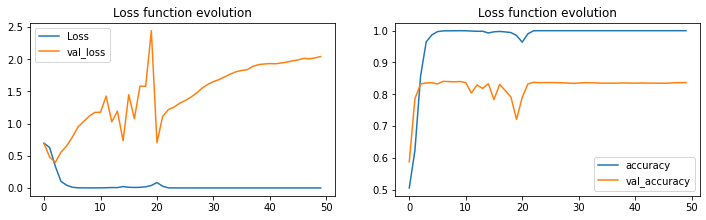

In [20]:
plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss function evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Loss function evolution')

In [21]:
# from sklearn.metrics import confusion_matrix, classification_report

# pred = model.predict(test_ds)

# print(confusion_matrix(raw_test_ds., pred > 0.5))

# Make an end-to-end model

If you want to obtain a model capable of processing raw strings, you can simply create a new model (using the weights we just trained)

In [22]:
# A string input
inputs = tf.keras.Input(shape=(1, ), dtype="string")

# Turn strings into vocab indices
indices = vectorize_layer(inputs)

# Turn vocab indices into predictions
outputs = model(indices)

# Our end to end model
end_to_end_model = tf.keras.Model(inputs, outputs)
end_to_end_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
)

# Test it with `raw_test_ds`, which yields raw strings
end_to_end_model.evaluate(raw_test_ds)

49/49 [==============================] - 7s 136ms/step - loss: 2.0297 - accuracy: 0.8361


[2.0297393798828125, 0.8361200094223022]